In [ ]:
import sys
!{sys.executable} -m pip install uv==0.6.14
!{sys.executable} -m uv pip sync ../requirements.txt

# Imports

In [3]:
import os

os.environ["BAYBE_TELEMETRY_ENABLED"] = "false"

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from baybe import Campaign
from baybe.acquisition import ProbabilityOfImprovement, LogExpectedImprovement
from baybe.objectives.base import Objective
from baybe.parameters import NumericalDiscreteParameter, SubstanceParameter
from baybe.recommenders import (
    BotorchRecommender,
    RandomRecommender,
    TwoPhaseMetaRecommender,
)
from baybe.searchspace import SearchSpace, SearchSpaceType
from baybe.simulation import simulate_scenarios
from baybe.targets import NumericalTarget
from baybe.utils import register_hooks
from baybe.utils.dataframe import to_tensor

from botorch.exceptions import InputDataWarning
from linear_operator.utils.warnings import NumericalWarning
import warnings

warnings.simplefilter("ignore", (InputDataWarning, NumericalWarning))

sns.set_context("paper", font_scale=1.7)

import baybe

print(baybe.__version__)

0.12.2


# Settings

In [4]:
from direct_arylation import substances, concentrations, temperatures, lookup

best_yield = lookup["yield"].max()

N_INTERRUPTED_CAMPAIGNS = 5
RANDOM_SEED = 1337

# Settings for the uninterrupted campaign
N_DOE_ITERATIONS = 25
N_MC_ITERATIONS = 20
BATCH_SIZE = 1

# Yield Cap
To illustrate the effect of stopping early, we artificially limit the best values possible in the search space.
This should prompt the interrupted campaigns to stop earlier and not seek better values of the yield above the cap for an extended amount of time.
Overall, this simulates a situation where, unknown to the experimentalist, the best possible achievable yield is 80%.
Since this is not the upper physical yield bound of 100%, it is not obvious that the campaign becomes unpromising and should be stopped.

In [5]:
YIELD_CAP = 80

# BayBE Setup

In [6]:
lookup.head()

,Concentration,Temp_C,Base,Ligand,Solvent,yield
0,0.1,105,Potassium acetate,BrettPhos,DMAc,5.47
1,0.1,105,Potassium acetate,Di-tert-butylphenylphosphine,DMAc,0.00
2,0.1,105,Potassium acetate,(t-Bu)PhCPhos,DMAc,78.95
3,0.1,105,Potassium acetate,Tricyclohexylphosphine,DMAc,7.26
4,0.1,105,Potassium acetate,PPh3,DMAc,28.15


In [7]:
parameters = [
    SubstanceParameter(name="Solvent", data=substances["solvents"], encoding="MORDRED"),
    SubstanceParameter(name="Base", data=substances["bases"], encoding="MORDRED"),
    SubstanceParameter(name="Ligand", data=substances["ligands"], encoding="MORDRED"),
    NumericalDiscreteParameter(name="Temp_C", values=temperatures),
    NumericalDiscreteParameter(name="Concentration", values=concentrations),
]

searchspace = SearchSpace.from_product(parameters=parameters)
objective = NumericalTarget(name="yield", mode="MAX").to_objective()
recommender = TwoPhaseMetaRecommender(
    initial_recommender=RandomRecommender(), recommender=BotorchRecommender()
)

campaign = Campaign(searchspace, objective, recommender)

In [8]:
# Exclude candidates above the yield cap
excluded = lookup[lookup["yield"] > YIELD_CAP]
campaign.toggle_discrete_candidates(excluded, exclude=True)
print("Excluded candidates: ", campaign._searchspace_metadata["excluded"].sum())

Excluded candidates:  67


# Uninterrupted Results
For this, we can use BayBE's simulation utility.

In [9]:
results_uninterrupted = simulate_scenarios(
    {"Average uninterrupted": campaign},
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
    random_seed=RANDOM_SEED,
)

100%|########################################################################################################################################################################################################################################| 20/20 [00:44<00:00,  2.22s/it]


# Define Stopping Logic

In [10]:
class CampaignStoppedException(Exception):
    """The campaign should be stopped."""


# Based on this exception class, we can now define a hook implementing the stopping
# criterion. For this purpose, we calculate the acquisition function values for the
# expected improvement. We do this by going via the LogExpectedImprovement for
# numerical reasons. Subsequently, we calculate the 0.5 quantile of these values.
# If the value is below 0.5, this means that less than 50% of candidates promise an
# expected yield improvement of 0.5 or more. In case this happens, we to stop the
# campaign by raising an exception.


def stop_on_EI(
    self: BotorchRecommender,
    batch_size: int,
    searchspace: SearchSpace,
    objective: Objective | None = None,
    measurements: pd.DataFrame | None = None,
    pending_experiments: pd.DataFrame | None = None,
) -> None:
    """Raise an exception if the EI-based stopping criterion is fulfilled."""

    acqf = LogExpectedImprovement()
    botorch_acqf = acqf.to_botorch(
        self._surrogate_model, searchspace, objective, measurements
    )
    _, candidates_comp_rep = searchspace.discrete.get_candidates()
    comp_rep_tensor = to_tensor(candidates_comp_rep).unsqueeze(1)
    acqf_values = torch.exp(botorch_acqf(comp_rep_tensor))

    if acqf_values.quantile(0.5) < 0.5:
        raise CampaignStoppedException(
            f"Stopping the campaign as the criterion has been met."
        )

# Interrupted Result

In [11]:
BotorchRecommender.recommend = register_hooks(
    BotorchRecommender.recommend, post_hooks=[stop_on_EI]
)


recommender_with_hook = TwoPhaseMetaRecommender(
    initial_recommender=RandomRecommender(), recommender=BotorchRecommender()
)
campaign_with_hook = Campaign(searchspace, objective, recommender)

# Exclude candidates above the yield cap
excluded = lookup[lookup["yield"] > YIELD_CAP]
campaign_with_hook.toggle_discrete_candidates(excluded, exclude=True)

results_interrupted = simulate_scenarios(
    {"Interrupted": campaign_with_hook},
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_INTERRUPTED_CAMPAIGNS,
    random_seed=RANDOM_SEED,
)

  0%|                                                                                                                                                                                                                                                  | 0/5 [00:00<?, ?it/s]/Users/*******/mambaforge/envs/py310-clean/lib/python3.10/site-packages/baybe/simulation/core.py:155: UserWarning: An error has occurred during the simulation, therefore incomplete simulation results are returned. The error message was:
Stopping the campaign as the criterion has been met.
  warnings.warn(
 20%|##############################################8                                                                                                                                                                                           | 1/5 [00:02<00:10,  2.57s/it]/Users/*******/mambaforge/envs/py310-clean/lib/python3.10/site-packages/baybe/simulation/core.py:155: UserWarning: An error has occurred during the simulat

# Visualization

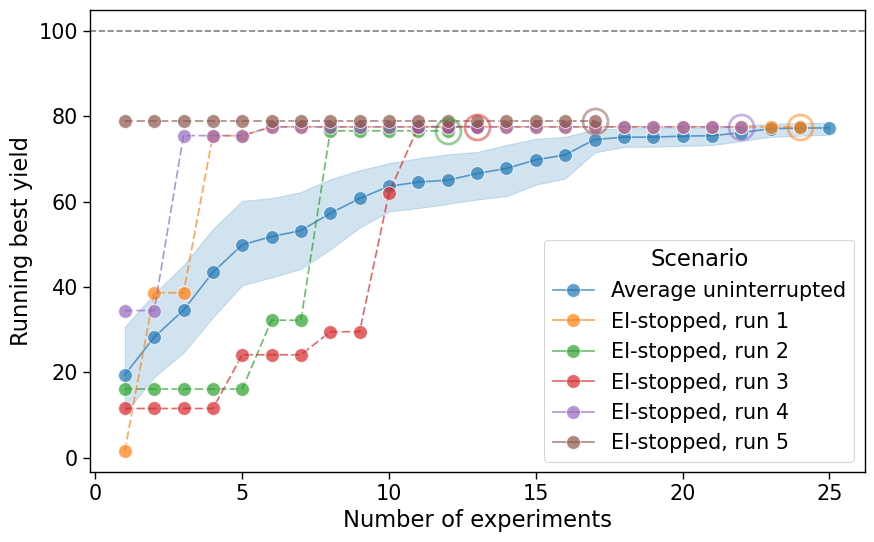

In [12]:
results_interrupted = results_interrupted.drop("Scenario", axis=1)
results_interrupted["Scenario"] = results_interrupted["Monte_Carlo_Run"].apply(
    lambda k: f"EI-stopped, run {k + 1}"
)

results = pd.concat([results_uninterrupted, results_interrupted])
results.rename(columns={"yield_CumBest": "Running best yield"}, inplace=True)

ax = sns.lineplot(
    data=results,
    marker="o",
    markersize=10,
    x="Num_Experiments",
    y="Running best yield",
    hue="Scenario",
    alpha=0.7,
)

# Set dashes for non-blue lines
for line in ax.get_lines()[1:]:
    line.set_dashes([5, 2])

# Add horizontal line for best yield
ax.axhline(best_yield, color="grey", linestyle="--")

plt.gcf().set_size_inches(10, 6)
plt.xlabel("Number of experiments")

# Adding special start markers at the last point of interrupted runs
for scenario in results["Scenario"].unique():
    scenario_data = results[results["Scenario"] == scenario]
    if not scenario_data.empty:
        last_point = scenario_data.iloc[-1]
        # Check if the last point is not at the maximum x value
        if last_point["Num_Experiments"] < results["Num_Experiments"].max():
            # Get the color of the corresponding line
            line_color = ax.get_lines()[
                results["Scenario"].unique().tolist().index(scenario)
            ].get_color()

            # Plot the special marker with a specific edge style
            ax.plot(
                last_point["Num_Experiments"],
                last_point["Running best yield"],
                marker="o",
                markersize=18,
                color="none",  # No fill color
                markeredgecolor=line_color,
                markeredgewidth=2,
                alpha=0.5,
            )

# Save the figure
ax.figure.savefig("../figures/campaign_stopping.svg", format="svg", transparent=True)
plt.show()